## Inititalize

Run install_libraries notebook first.

General

In [1]:
import pandas as pd
import numpy as np
from dask.distributed import Client
from dask import delayed
import dask.dataframe as dd
import dask, ast, itertools
import dask_ml.model_selection as dcv

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import datetime as dt
import boto3, yaml
from sagemaker import get_execution_role
from datetime import timedelta

from scipy.stats import expon

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler, label_binarize, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
import itertools
from sklearn.metrics import roc_curve, auc, precision_score, f1_score, recall_score, average_precision_score, precision_recall_curve, confusion_matrix, classification_report

import sys,os, joblib
util_path = os.path.abspath(os.path.join(os.path.pardir, '../sasse-polygon-process/lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
    
from util import evaluate, feature_selection
from config import read_options
from viz import Viz
from filehandler import FileHandler

sns.set()
sns.set_style("whitegrid")
%matplotlib inline

Using TensorFlow backend.


Following snippet is used to get forest columns from database (inserted into ../cnf/rfc.ini)

In [2]:
print(dask.__version__)
print(pd.__version__)

2.12.0
1.0.3


In [3]:
client = Client('Dask-Scheduler.local-dask:8786')
client.get_versions(check=True)
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 3 Cores: 6 Memory: 25.77 GB


In [ ]:
client.restart()

In [4]:
#fh = FileHandler() #s3_bucket='fmi-sasse-classification-dataset')
#viz = Viz()

In [4]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'forest'
read_options(options)

options_ene = Options()
options_ene.config_filename = '../cnf/rfc.ini'
options_ene.config_name = 'forest_energiateollisuus'
read_options(options_ene)

options_ene_thin = Options()
options_ene_thin.config_filename = '../cnf/rfc.ini'
options_ene_thin.config_name = 'thin_energiateollisuus'
read_options(options_ene_thin)

## Functions

Needed to visualise trained models later:

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.YlOrBr,
                          filename=None,
                          fontsize=20):
        """
        Normalization can be applied by setting `normalize=True`.
        """
        plt.clf()
        plt.rc('font', size=fontsize)

        fig, ax = plt.subplots(figsize=(6,6))
        np.set_printoptions(precision=2)
        cm = confusion_matrix(y_true, y_pred)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.grid(False, which='major')
        
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        tick_marks = np.arange(len(classes))
        ax.xaxis.tick_top()
        plt.xticks(tick_marks, classes) #, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        fig.subplots_adjust(bottom=0.12)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [6]:
def prec_rec_curve(y, y_pred, n_classes, fontsize=20):
    """
    Precision - Recall Curve
    """
    plt.rc('font', size=fontsize)

    y = label_binarize(y, classes=np.arange(n_classes))

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(), y_pred.ravel())
    average_precision["micro"] = average_precision_score(y, y_pred, average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

    plt.figure(figsize=(12, 12))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y_ = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y_ >= 0], y_[y_ >= 0], color='gray', alpha=0.5)
        plt.annotate('F1={0:0.1f}'.format(f_score), xy=(0.9, y_[45] + 0.02))

    lines.append(l)
    labels.append('F1 curves')

    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('Micro-average (area = {0:0.2f})'
    ''.format(average_precision["micro"]))

    for i in range(n_classes):
        l, = plt.plot(recall[i], precision[i], lw=2)
        lines.append(l)
        labels.append('Class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(np.arange(.2, 1., .2))
    plt.xlabel('Recall', labelpad=20)
    plt.ylabel('Precision', labelpad=20)
    plt.title('Precision-Recall Curve', pad=20)
    plt.legend(lines, labels, loc=(0, -.2), ncol=2)

In [7]:
def feature_importance(data, feature_names = None, fontsize=20):
    """ Plot feature importance """

    fig, ax = plt.subplots(figsize=(24,18))

    plt.clf()
    plt.rc('font', size=fontsize)

    if feature_names is None:
        feature_names = range(0,len(data))
    else:
        plt.xticks(rotation=90, fontsize=fontsize)
        fig.subplots_adjust(bottom=0.5)

    plt.yticks(fontsize=fontsize*2/3)
    plt.bar(feature_names, data, align='center')
    plt.xlabel('Components', fontsize=fontsize, labelpad=20)
    plt.ylabel('Importance', fontsize=fontsize, labelpad=20)
    
    #ax.tick_params(axis='both', which='major', labelsize=fontsize)
    #ax.tick_params(axis='both', which='minor', labelsize=fontsize)
    
    # plt.tight_layout()
    #fig.subplots_adjust(bottom=0.5)

    #self._save(plt, filename)

In [8]:
def cv(model, param_grid, X, y, n_iter=20): 
    cv_results = None
    print('..performing cv search...')
    searches = []

    # Define jobs
    random_search = dcv.RandomizedSearchCV(model, 
                                           param_grid, 
                                           n_iter=n_iter,
                                           scoring=['f1_macro', 'f1_micro', 'accuracy'],
                                           return_train_score=True,
                                           refit=False).fit(X, y)
    # Gather results
    cv_results = pd.DataFrame(random_search.cv_results_) #.head(1)    
    cv_results.sort_values(by=['mean_test_f1_macro'], inplace=True, ascending=False, ignore_index=True)
    print(cv_results.head())
    
    best_params = cv_results.loc[0,'params']
    model = model.set_params(**best_params)

    print('Using configuration: {}'.format(best_params))

    with joblib.parallel_backend('dask'):
        model.fit(X, y)
        
    return model, cv_results

In [9]:
def gridcv(model, param_grid, X, y): 
    cv_results = None
    print('..performing cv search...')
    searches = []

    # Define jobs
    grid_search = dcv.GridSearchCV(model, 
                                   param_grid, 
                                   scoring=['f1_macro', 'f1_micro', 'accuracy'],
                                   return_train_score=True,
                                   refit=False,
                                   n_jobs=-1).fit(X, y)
    
    # Gather results
    cv_results = pd.DataFrame(grid_search.cv_results_) #.head(1)    
    cv_results.sort_values(by=['mean_test_f1_macro'], inplace=True, ascending=False, ignore_index=True)
    print(cv_results.head())
    
    best_params = cv_results.loc[0,'params']
    model = model.set_params(**best_params)

    print('Using configuration: {}'.format(best_params))

    with joblib.parallel_backend('dask'):
        model.fit(X, y)
        
    return model, cv_results

In [10]:
def read_data(fname_train, fname_test, options):
    """ Read data from csv file """
    
    # Train
    data_train = pd.read_csv(fname_train)

    X_train = data_train.loc[:, options.feature_params]
    y_train = data_train.loc[:, options.label].values.ravel()
    
    print('Train data shape: {}'.format(X_train.shape))
    
    # Test
    data_test = pd.read_csv(fname_test)

    X_test = data_test.loc[:, options.feature_params]
    y_test = data_test.loc[:, options.label].values.ravel()
    
    print('Test data shape: {}'.format(X_test.shape))
    
    return X_train, y_train, X_test, y_test

## Loiste-JSE

### Get data

In [59]:
X_train, y_train, X_test, y_test = read_data('../data/loiste_jse_small_train.csv', '../data/loiste_jse_all_test.csv', options)
#X_train, y_train, X_test, y_test = read_data('../data/loiste_jse_tiny_train.csv', '../data/loiste_jse_all_test.csv', options)

Train data shape: (1447, 58)
Test data shape: (1670, 58)


## Train

In [60]:
kernel = PairwiseKernel(metric='laplacian') *  DotProduct()
gpc_compound = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc_compound.fit(X_train, y_train)

<Figure size 432x288 with 0 Axes>

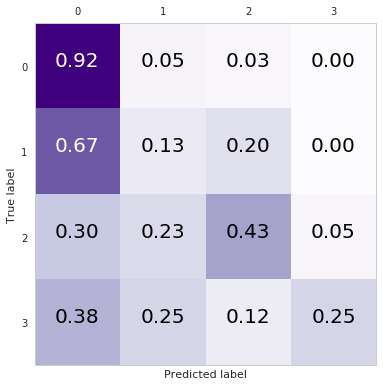

In [61]:
y_pred_proba = gpc_compound.predict_proba(X_test.values)
y_pred = np.argmax(y_pred_proba, axis=1)
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Purples)

Average precision score, micro-averaged over all classes: 0.94


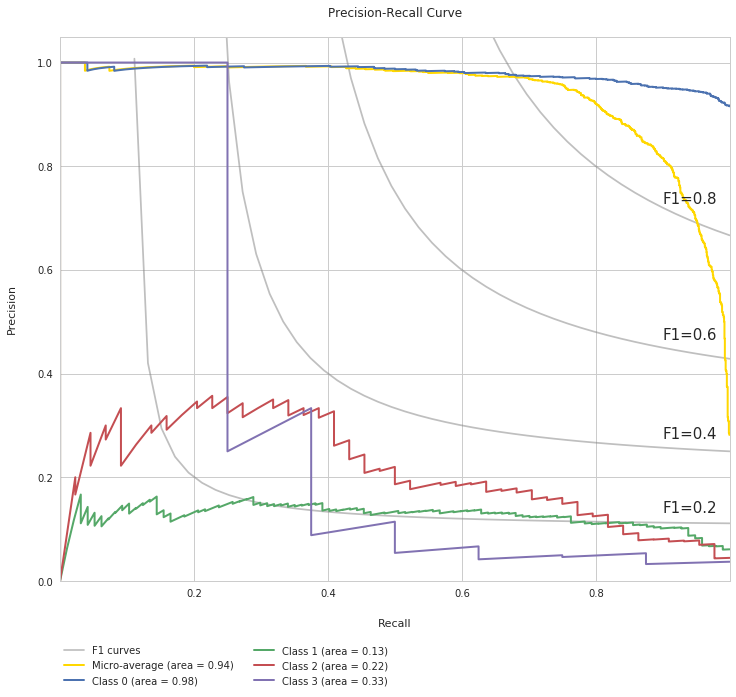

In [65]:
prec_rec_curve(y_test, y_pred_proba, 4, fontsize=15)

In [63]:
for i,c in enumerate(y_test):
    if c == 3 or y_pred[i] == 3:
        print('True: {} | Predicted: {}'.format(c, y_pred[i]))

True: 2 | Predicted: 3
True: 3 | Predicted: 1
True: 3 | Predicted: 0
True: 3 | Predicted: 0
True: 3 | Predicted: 0
True: 3 | Predicted: 1
True: 3 | Predicted: 3
True: 3 | Predicted: 2
True: 0 | Predicted: 3
True: 0 | Predicted: 3
True: 0 | Predicted: 3
True: 2 | Predicted: 3
True: 3 | Predicted: 3


In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1521
           1       0.13      0.13      0.13        97
           2       0.24      0.43      0.31        44
           3       0.29      0.25      0.27         8

    accuracy                           0.86      1670
   macro avg       0.40      0.43      0.41      1670
weighted avg       0.88      0.86      0.87      1670



## Energiateollisuus

### Get data

In [11]:
X_train_ene, y_train_ene, X_test_ene, y_test_ene = read_data('../data/energiateollisuus_small_train.csv', '../data/energiateollisuus_all_test.csv', options)

Train data shape: (4000, 58)
Test data shape: (28296, 58)


## Train

In [12]:
kernel = PairwiseKernel(metric='laplacian') *  DotProduct()
gpc_ene = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc_ene.fit(X_train_ene, y_train_ene)

<Figure size 432x288 with 0 Axes>

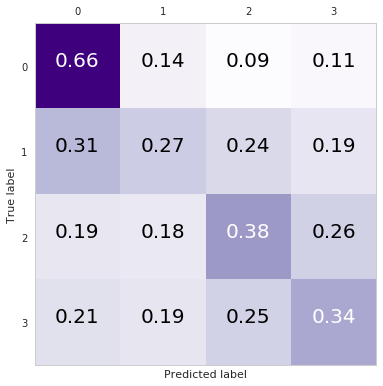

In [13]:
y_pred_proba_ene = gpc_ene.predict_proba(X_test_ene.values)
y_pred_ene = np.argmax(y_pred_proba_ene, axis=1)
plot_confusion_matrix(y_test_ene, y_pred_ene, range(0,4), normalize=True, cmap=plt.cm.Purples)

Average precision score, micro-averaged over all classes: 0.67


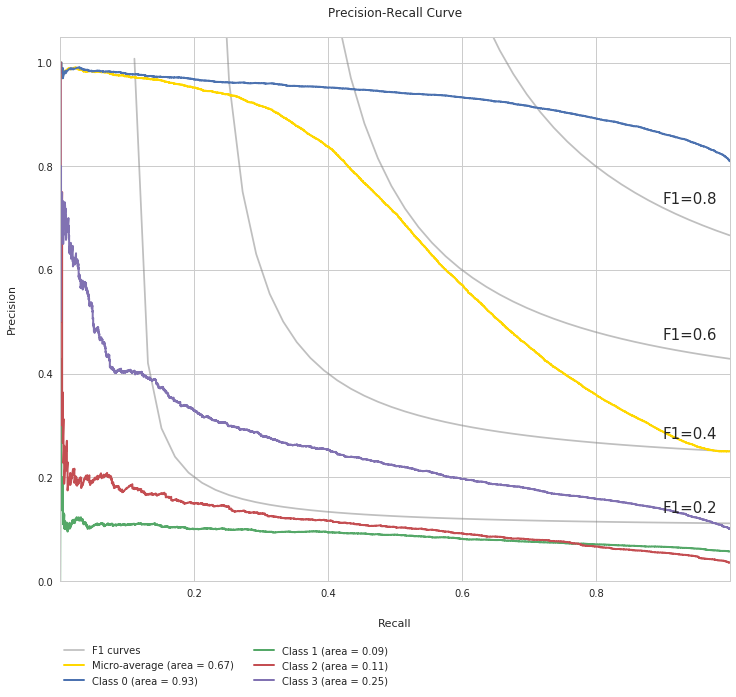

In [14]:
prec_rec_curve(y_test_ene, y_pred_proba_ene, 4, fontsize=15)

In [16]:
print(classification_report(y_test_ene, y_pred_ene))

              precision    recall  f1-score   support

           0       0.92      0.66      0.77     22895
           1       0.10      0.27      0.14      1607
           2       0.10      0.38      0.16       982
           3       0.24      0.34      0.28      2812

    accuracy                           0.60     28296
   macro avg       0.34      0.41      0.34     28296
weighted avg       0.78      0.60      0.66     28296



distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
